# Семинарская работа по AutoML

##### Цель работы:
Получить практические навыки по работе с AutoML моделями и сравнить их эффективность по сравнению друг с другом.


В качестве моделей для сравнения были расмотрены следующие autoML:


- AutoGluon
- Fedot
- LightAutoML
- MLJAR

Датасет для обучения был взят с kaggle: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction.
##### Краткое описание датасета:
Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of 5CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

This dataset was created by combining different datasets already available independently but not combined before. In this dataset, 5 heart datasets are combined over 11 common features which makes it the largest heart disease dataset available so far for research purposes.

### Ход работы:

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from autogluon.tabular import TabularPredictor

from fedot.api.main import Fedot

from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

from supervised.automl import AutoML

from sklearn.metrics import f1_score
import time

/Users/mikhailvokhrameev/3year/MLclassic/AutoML_heart/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Загрузка датасета и разделение его на train и test, т.к. в исходном такого нет.

In [3]:
df = pd.read_csv("./data/heart.csv")
TARGET = "HeartDisease"
FEATURES = df.drop(TARGET, axis=1).columns

##### Проведем некоторый EDA:

In [4]:
print("Информация о данных:")
print(df.info())
print("Пропуски:")
print(df.isnull().sum().sum())

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None
Пропуски:
0


##### Описательная статистика:

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


##### Визуализация распределения целевой переменной:

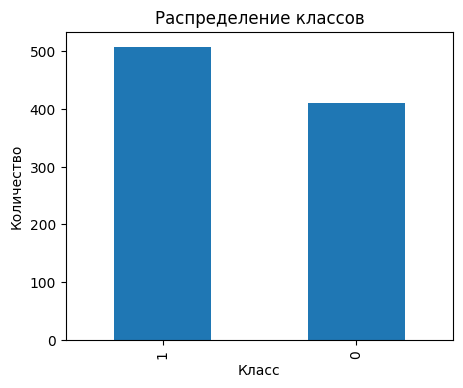

In [5]:
plt.figure(figsize=(5,4))
df[TARGET].value_counts().plot(kind='bar')
plt.title("Распределение классов")
plt.xlabel("Класс")
plt.ylabel("Количество")
plt.show()

Классы почти сбалансированы, что не может не радовать.

Напоследок построим Boxplot для поиска выбросов:

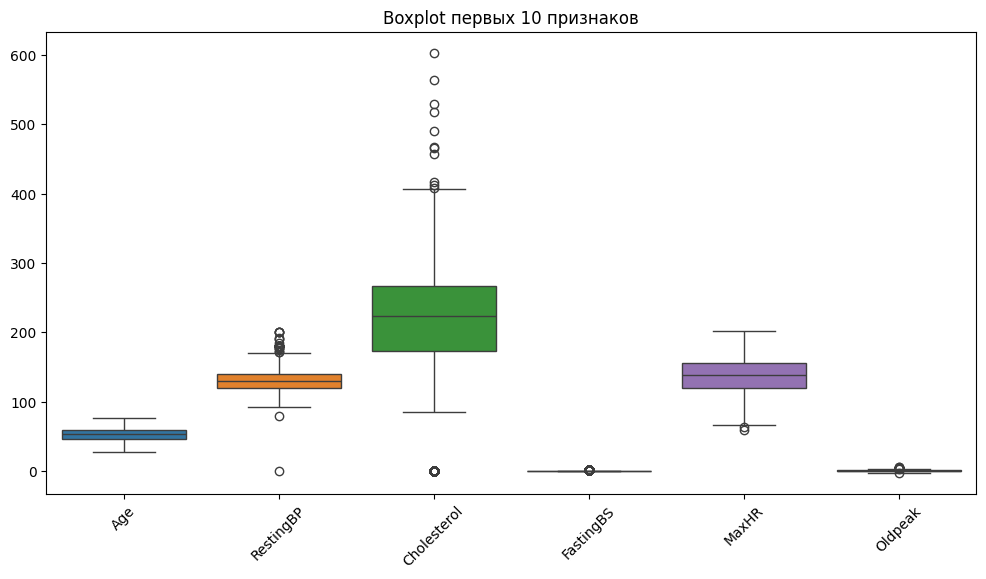

In [6]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df.drop(columns=[TARGET]).iloc[:, :10])
plt.xticks(rotation=45)
plt.title("Boxplot первых 10 признаков")
plt.show()

Выбросы есть, но их в целом немного.

##### Предобработка данных:
Т.к мы используем AutoML, то не будем делать ручную предобработку, ведь модель прекрасно справится с этим сама.

Разобъем исходный датасет на тренировочную (80% датасета) и тестовую (20% датасета) выборки:

In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df[TARGET], random_state=42)

print(f"Train shape:{train_df.shape}")
print(f"Test shape:{test_df.shape}")

Train shape:(734, 12)
Test shape:(184, 12)


#### Обучение моделей:

##### 1. AutoGluon

AutoGluon, разработанный Amazon, предназначен для достижения высокой производительности с минимальным вмешательством пользователя. Его сила заключается в многослойной стратегии стекирования и ансамблирования.

Вместо того, чтобы исчерпывающе искать лучшие гиперпараметры для одной модели, AutoGluon параллельно обучает широкий спектр моделей, включая LightGBM, CatBoost, XGBoost, Random Forests и свои собственные настраиваемые нейронные сети. Окончательный предиктор обычно представляет собой взвешенный ансамбль моделей с наилучшей производительностью. Этот подход является надежным и часто дает лучшие результаты, чем любая отдельная модель.

Предобработка данных для AutoGluon не требуется, так как он автоматически обрабатывает общие проблемы с данными, такие как отсутствующие значения и кодирование категориальных признаков.

Для начала также стоит определиться с метрикой, по которой будет определяться лучшая модель. Так как у нас стоит задача классификации - есть ли у нас болезнь сердца или нет, то нужно использовать метрики классификации. Возьмем F1-score.

Ниже создается объект предсказателя TabularPredictor. В качестве параметров мы заносим наш таргет, путь куда мы будем сохранять модели и результаты, метрику, которую мы используем.

В качестве параметров обучения задаем тренировочный датасет, ограничение по времени обучения в секундах, пресет (насколько качественного результата мы хотим добиться, а мы хотим самого качественного), и в конце задаем насколько хотим детализованный вывод.

In [ ]:
metric = "f1"
predictor = TabularPredictor(label=TARGET, path="autogluon_heartdiseasse_output", eval_metric=metric).fit(
    train_data=train_df,
    time_limit=300,
    presets="best_quality",
    verbosity=2
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.10.18
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          4
Memory Avail:       2.37 GB / 15.96 GB (14.8%)
Disk Space Avail:   538.74 GB / 953.03 GB (56.5%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is use

Мы обучили наш предиктор и теперь мы знаем лучшую модель:

In [10]:
best_model = predictor.model_best
print(f"Best model: {best_model}")

Best model: WeightedEnsemble_L3


Также ради интереса можно посмотреть Leaderboard:

In [11]:
leaderboard = predictor.leaderboard()
leaderboard

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM_BAG_L2,0.912114,f1,0.528077,103.936498,0.038614,10.068461,2,True,12
1,WeightedEnsemble_L3,0.912114,f1,0.531831,104.297149,0.003754,0.360650,3,True,16
2,LightGBMXT_BAG_L2,0.905840,f1,0.555201,105.234707,0.065738,11.366670,2,True,11
3,RandomForestEntr_BAG_L2,0.898551,f1,0.616237,94.641882,0.126774,0.773845,2,True,14
4,LightGBMXT_BAG_L1,0.897467,f1,0.039002,8.579469,0.039002,8.579469,1,True,1
5,WeightedEnsemble_L2,0.897467,f1,0.041885,9.055997,0.002883,0.476528,2,True,10
6,RandomForestGini_BAG_L2,0.895054,f1,0.614224,94.669215,0.124761,0.801178,2,True,13
7,LightGBM_BAG_L1,0.890476,f1,0.028385,10.817938,0.028385,10.817938,1,True,2
8,CatBoost_BAG_L2,0.888355,f1,0.538176,122.297342,0.048712,28.429305,2,True,15
9,XGBoost_BAG_L1,0.885478,f1,0.060012,9.540720,0.060012,9.540720,1,True,9


Проведем оценку на тестовой выборке:

In [12]:
test_score = predictor.evaluate(test_df, decision_threshold=0.5)
autogluon_f1 = test_score['f1']
print(f"AutoGluon F1 Score: {autogluon_f1}")

AutoGluon F1 Score: 0.9082125603864735


Лучшая модель, которую подобрал AutoML - `WeightedEnsemble_L3`. Это модель третьего уровня стекинга, которая агрегирует выходы моделей предыдущих уровней, чтобы получить итоговое предсказание с помощью взвешенного ансамблирования. WeightedEnsemble_L3 — это не отдельная ML-модель, а агрегатор, который строит оптимальную (на валидации) взвешенную комбинацию прогнозов всех моделей предыдущего уровня с помощью так называемого greedy ensemble selection.

Т.к. классификация - бинарная и метрика f1, то autogluon также пытается подобрать подходящий порог для вероятностей классов (т.к. они необязательно сбалансированы). Т.к. датасет подобран специально почти сбалансированный, то лучший порог, который он нашел равен 0.5. 

##### 2. Fedot


Fedot — это фреймворк AutoML, который использует эволюционные алгоритмы для автоматического проектирования конвейеров машинного обучения. Он рассматривает построение конвейера как задачу оптимизации. Он представляет весь рабочий процесс машинного обучения — от предварительной обработки данных до моделирования — в виде графа. Каждый узел в графе представляет собой операцию с данными (например, масштабирование) или модель машинного обучения (например, Random Forest).

Fedot начинает с популяции случайно сгенерированных конвейеров. Затем он «развивает» эту популяцию на протяжении нескольких поколений, чтобы найти лучший конвейер: зачастую с более высокой метрикой F1.


Обучим Fedot на нашем датасете, указав, какую задачу мы решаем (классификация), и сделаем отбор по f1-score.

In [13]:
fedot_model = Fedot(
    problem='classification',
    timeout=5,             # Время в минутах
    preset='best_quality',
    metric='f1',
    n_jobs=-1,
    seed=42                # Для воспроизводимости
)

fedot_model.fit(features=train_df[FEATURES], target=train_df[TARGET])


2025-10-11 21:31:01,140 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-10-11 21:31:03,758 - ApiComposer - Initial pipeline was fitted in 1.5 sec.
2025-10-11 21:31:03,760 - ApiComposer - Taking into account n_folds=5, estimated fit time for initial assumption is 7.3 sec.
2025-10-11 21:31:03,776 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 5 min. Set of candidate models: ['bernb', 'catboost', 'dt', 'fast_ica', 'isolation_forest_class', 'knn', 'lgbm', 'logit', 'mlp', 'normalization', 'pca', 'poly_features', 'qda', 'resample', 'rf', 'scaling', 'xgboost'].
2025-10-11 21:31:04,072 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 0/10000 [00:00<?, ?gen/s]

2025-10-11 21:31:27,917 - MultiprocessingDispatcher - 6 individuals out of 6 in previous population were evaluated successfully.
2025-10-11 21:31:38,161 - MultiprocessingDispatcher - 20 individuals out of 21 in previous population were evaluated successfully.
2025-10-11 21:31:52,913 - MultiprocessingDispatcher - 8 individuals out of 9 in previous population were evaluated successfully.
2025-10-11 21:31:54,616 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2025-10-11 21:31:57,776 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.


Generations:   0%|          | 1/10000 [00:53<149:08:03, 53.69s/gen]

2025-10-11 21:32:00,612 - MultiprocessingDispatcher - 12 individuals out of 12 in previous population were evaluated successfully.
2025-10-11 21:32:04,670 - MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


Generations:   0%|          | 2/10000 [01:00<72:39:56, 26.16s/gen] 

2025-10-11 21:32:12,531 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2025-10-11 21:32:16,806 - MultiprocessingDispatcher - 13 individuals out of 13 in previous population were evaluated successfully.


Generations:   0%|          | 3/10000 [01:12<54:52:44, 19.76s/gen]

2025-10-11 21:32:29,343 - MultiprocessingDispatcher - 33 individuals out of 33 in previous population were evaluated successfully.
2025-10-11 21:32:29,375 - MultiprocessingDispatcher - 14 individuals out of 14 in previous population were evaluated successfully.


Generations:   0%|          | 4/10000 [01:25<46:58:27, 16.92s/gen]

2025-10-11 21:32:31,577 - MultiprocessingDispatcher - 13 individuals out of 13 in previous population were evaluated successfully.
2025-10-11 21:32:36,016 - MultiprocessingDispatcher - 14 individuals out of 14 in previous population were evaluated successfully.
2025-10-11 21:32:40,883 - MultiprocessingDispatcher - 14 individuals out of 14 in previous population were evaluated successfully.
2025-10-11 21:32:46,384 - MultiprocessingDispatcher - 14 individuals out of 14 in previous population were evaluated successfully.
2025-10-11 21:32:47,696 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.


Generations:   0%|          | 5/10000 [01:43<48:22:33, 17.42s/gen]

2025-10-11 21:33:11,702 - MultiprocessingDispatcher - 47 individuals out of 49 in previous population were evaluated successfully.


Generations:   0%|          | 6/10000 [02:07<54:36:47, 19.67s/gen]

2025-10-11 21:33:40,663 - MultiprocessingDispatcher - 50 individuals out of 51 in previous population were evaluated successfully.


Generations:   0%|          | 8/10000 [03:18<79:34:24, 28.67s/gen]

2025-10-11 21:34:22,345 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 8/10000 [03:18<68:47:04, 24.78s/gen]

2025-10-11 21:34:22,390 - ApiComposer - Hyperparameters tuning started with 2 min. timeout


2025-10-11 21:34:37,064 - SimultaneousTuner - Initial graph: {'depth': 3, 'length': 4, 'nodes': [logit, rf, scaling, isolation_forest_class]}
logit - {}
rf - {'n_jobs': 1, 'criterion': 'entropy', 'max_features': 0.30237179109719853, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': True}
scaling - {}
isolation_forest_class - {} 
Initial metric: [0.852]
  0%|          | 7/100000 [01:33<371:55:43, 13.39s/trial, best loss: -0.8301781608308513]
2025-10-11 21:36:23,749 - SimultaneousTuner - Final graph: {'depth': 3, 'length': 4, 'nodes': [logit, rf, scaling, isolation_forest_class]}
logit - {}
rf - {'n_jobs': 1, 'criterion': 'entropy', 'max_features': 0.30237179109719853, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': True}
scaling - {}
isolation_forest_class - {}
2025-10-11 21:36:23,764 - SimultaneousTuner - Final metric: 0.852
2025-10-11 21:36:23,770 - ApiComposer - Hyperparameters tuning finished
2025-10-11 21:36:23,959 - ApiComposer - Model generation finished
202

{'depth': 3, 'length': 4, 'nodes': [logit, rf, scaling, isolation_forest_class]}

Узнаем f1-score на тестовой выборке

In [14]:
fedot_preds = fedot_model.predict(features=test_df[FEATURES])
fedot_f1 = f1_score(test_df[TARGET], fedot_preds)

print(f"Fedot F1-Score: {fedot_f1:.4f}")

Fedot F1-Score: 0.9100


Посмотрим пайплайн, который вывел Fedot


In [15]:
fedot_model.current_pipeline.print_structure()

Pipeline structure:
{'depth': 3, 'length': 4, 'nodes': [logit, rf, scaling, isolation_forest_class]}
logit - {}
rf - {'n_jobs': 4, 'criterion': 'entropy', 'max_features': 0.30237179109719853, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': True}
scaling - {}
isolation_forest_class - {}


В данном выводе мы видим структуру пайплайна, а именно:
- `depth`: 3 - Длина самого длинного пути от входных данных до финального результата. Глубина 3 при длине 4 указывает на то, что в пайплайне есть параллельные ветви.
- `length`: 4 — Общее количество узлов (моделей и шагов обработки) в пайплайне.

`scaling` - Это узел предварительной обработки данных. Он выполняет масштабирование признаков (например, стандартизацию), приводя их к единому диапазону. Пустые параметры {} означают, что используется реализация по умолчанию. Для `scaling` это `StandardScaler`, который усредняет каждый признак. 

`isolation_forest_class` - Алгоритм, изначально разработанный для поиска аномалий, но адаптированный для задач классификации. По умлочанию это `IsolationForest` из библиотеки `scikit-learn`

`rf` - Random forest - мощный ансамблевый метод, состоящий из множества деревьев решений. Его гиперпараметры настроены FEDOT для оптимальной производительности.

`logit` - Это модель логистической регрессии. Она не работает с исходными признаками, а принимает на вход предсказания от `rf` и `isolation_forest_class` и на их основе делает финальное предсказание. Значение по умолчанию: `LogisticRegression` из `scikit-learn`. 

Исходя из этого, полученный pipeline состоит из 5 узлов (операций), организованных в 3 уровня глубины. Данные проходят следующую обработку:
1) `scaling`: На первом шаге исходные данные проходят через узел scaling. Это операция по масштабированию признаков, которая приводит все признаки к одному масштабу.

2) `catboost`, `xgboost`, `knn`: Масштабированные данные параллельно подаются на вход трем разным моделям машинного обучения: CatBoost, XGBoost и KNN. Каждая из этих моделей делает свое собственное предсказание.

3) `logit`: На последнем шаге предсказания, полученные от catboost, xgboost и knn, объединяются и используются как новые признаки для логистической регрессии. Эта модель обучается на предсказаниях базовых моделей и выносит итоговое решение. Такая архитектура называется стекингом.

##### 3. LightAutoML


LightAutoML разработан в Sber AI Lab. Является победителем соревнований Kaggle AutoML Grand Prix 2024. Специализируется на работе с табличными данными (но также способен обрабатывать и тексты, и картинки) и отличается высокой скоростью и эффективностью, особенно на больших датасетах.

LightAutoML строит полный ML пайплайн: определяет роли признаков, делает препроцессинг по типам данных, перебирает и валидирует модели по пресетам, тюнит гиперпараметры и собирает финальный бленд/стекинг с отчетом об интерпретации и качестве.

Ниже создается объект предсказателя TabularAutoML для LightAutoML. В качестве параметров мы заносим task_type, метрику, которую мы используем.

В качестве параметров обучения задаем тренировочный датасет и таргет.

In [13]:
task = Task(name='binary', metric='auc')

predictor_light = TabularAutoML(
    task=task,
    timeout=300,
    reader_params={'random_state': 42},
)

oof_preds = predictor_light.fit_predict(train_df, roles = {'target': TARGET}).data
test_preds = predictor_light.predict(test_df).data

2025-10-13 19:45:09,566 - Stdout logging level is ERROR.
2025-10-13 19:45:09,568 - Task: binary

2025-10-13 19:45:09,569 - Start automl preset with listed constraints:
2025-10-13 19:45:09,569 - - time: 300.00 seconds
2025-10-13 19:45:09,570 - - CPU: 4 cores
2025-10-13 19:45:09,570 - - memory: 16 GB

2025-10-13 19:45:09,570 - Train data shape: (734, 12)

2025-10-13 19:45:11,832 - Layer 1 train process start. Time left 297.74 secs
2025-10-13 19:45:11,866 - Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
2025-10-13 19:45:12,308 - Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9091823861588371
2025-10-13 19:45:12,309 - Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
2025-10-13 19:45:12,310 - Time left 297.26 secs

2025-10-13 19:45:12,423 - Selector_LightGBM fitting and predicting completed
2025-10-13 19:45:12,431 - Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
2025-10-13 19:45:13,457 - Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8400516640634387
2025-10-13 1

Узнаем f1-score на тестовой выборке

In [20]:
threshold = 0.5
y_hat = (test_preds >= threshold).astype(int)
y_true = test_df[TARGET]
lightautoml_f1 = f1_score(y_true, y_hat)
print(f"LightAutoML F1-Score: {lightautoml_f1:.4f}")

LightAutoML F1-Score: 0.9135


Описание получившегося конвейера:

In [16]:
print(predictor_light.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.51123 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.06707 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.42170 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 


Мы получили взвешенный ансамбль из 3 семейств моделей. Каждое семейство - это усреднение 5 моделей, обученных на разных фолдах. У нас 5 линейных моделей с L2 регуляризацией, 5 LightGBM моделей, 5 Catboost моделей.

##### 4. MLJAR

MLJAR-supervised от MLJAR. Умеет строить бейзлайн и сравнивать наши ML модели с бейзлайном. Тренирует простые решающие деревья с max_depth <= 5. Использует много алгоритмов: Baseline, Linear, Random Forest, Extra Trees, LightGBM, Xgboost, CatBoost, Neural Networks, и Nearest Neighbors. Может делать препроцессинг фичей, тюнинг гиперпараметров с помощью not-so-random-search алгоритма и еще много интересных вещей...

Также есть веб приложение, чтобы не писать код вообще, а также авто генератор отчетов.

In [6]:
automl_mljar = AutoML(mode="Perform", eval_metric="f1", total_time_limit=300, random_state=42) # использует 5-fold CV: Linear, Random Forest, LightGBM, Xgboost, CatBoost, и Neural Network
automl_mljar.fit(train_df[FEATURES], train_df[TARGET])
predictions = automl_mljar.predict(test_df[FEATURES])

AutoML directory: AutoML_4
The task is binary_classification with evaluation metric f1
AutoML will use algorithms: ['Linear', 'Random Forest', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble']
* Step simple_algorithms will try to check up to 1 model
1_Linear f1 0.862069 trained in 4.64 seconds (1-sample predict time 0.0513 seconds)
* Step default_algorithms will try to check up to 5 models
2_Default_LightGBM f1 0.892344 trained in 4.52 seconds (1-sample predict time 0.01 seconds)
3_Default_Xgboost f1 0.886284 trained in 2.79 seconds (1-sample predict time 0.0235 seconds)
4_Default_CatBoost f1 0.898447 trained in 2.37 seconds (1-sample predict time 0.0074 seconds)
5_Default_NeuralNetwork f1 0.864407 trained in 2.55 seconds (1-sample predict time 0.0236 second

Узнаем f1-score на тестовой выборке

In [7]:
y_true = test_df[TARGET]
mljar_f1 = f1_score(y_true, predictions)
print(f"MLJar F1-Score: {mljar_f1:.4f}")

MLJar F1-Score: 0.9082


##### Сравнение всех моделей

In [8]:
results = {
    'Library': ['AutoGluon', 'Fedot', 'LightAutoML', 'MLJar'],
    # 'F1-Score': [autogluon_f1, fedot_f1, lightautoml_f1, mljar_f1]
    'F1-Score': [0.9082, 0.9100, 0.9135, 0.9082]
    # делаем так, потому что обучали разные авто млки на разных компах и 
    # если ставить все на одно виртуальное окружение, то возникают конфликты библиотек...
}

results_df = pd.DataFrame(results).sort_values(by='F1-Score', ascending=False)

print("Результат сравнения разных библиотек AutoML")
print(results_df)

Результат сравнения разных библиотек AutoML
       Library  F1-Score
2  LightAutoML    0.9135
1        Fedot    0.9100
0    AutoGluon    0.9082
3        MLJar    0.9082


#### Вывод

Судя по таблице победил LightAutoML с F1-Score = 0.9135. В целом, все библиотеки AutoML показали очень высокий и схожий результат. Хочется выделить LightAutoML за его классную документацию и курсы на русском языке и MLJar за веб приложение и авто отчеты.